In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Installations

In [2]:
!pip install rembg
!pip install diffusers
!pip install torch
!pip install compel
!pip install cv2
!pip install numpy
!pip install controlnet_aux

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.1 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.4/202.4 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.4 MB/s eta 0:00:00
  Created wheel for controlnet_aux: filename=controlnet_aux-0.0.7-py3-none-any.whl size=274344 sha256=0004f7cb76b7d17761b76ad3e115aaec3acd4262364c3bd426a50b4f8143fc4b
  Stored in directory: /root/.cache/pip/wheels/1e/3e/93/6678b4c0bc2ec31d53409b25d4189cbb08bae843e8b2b78e52


In [3]:
import numpy as np
from PIL import Image
from rembg import remove, new_session
import requests
from io import BytesIO
import torch
from compel import Compel
import cv2

In [4]:
from controlnet_aux import HEDdetector

/opt/conda/lib/python3.10/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/controlnet_aux/segment_anything/modeling/tiny_vit_sam.py:654: UserWarning: Overwriting tiny_vit_5m_224 in registry with controlnet_aux.segment_anything.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/opt/conda/lib/python3.10/site-packages/controlnet_aux/segment_anything/modeling/tiny_vit_sam.py:654: UserWarning: Overwriting tiny_vit_11m_224 in registry with controlnet_aux.segment_anything.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.

In [5]:
def load_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img

In [6]:
# rembg method
rembg_session = new_session("isnet-general-use")

def segment_image(image: Image.Image) -> np.ndarray:
    return np.asarray(remove(image, session= rembg_session, alpha_matting=True, alpha_matting_foreground_threshold=270, alpha_matting_background_threshold=20, alpha_matting_erode_size=11))

# Generate mask
def mask_image(image: Image.Image) -> np.ndarray:
    segmented_image = segment_image(image)
    mask_image = Image.fromarray(segmented_image).split()[-1]
    return np.asarray(mask_image)


def get_canny(img: np.ndarray) -> np.ndarray:
    canny_image = cv2.Canny(img, 100, 200)
    canny_image = canny_image[:, :, None]
    canny_image = np.concatenate([canny_image, canny_image, canny_image], axis=2)
    return canny_image


def get_HED(img: np.ndarray) -> np.ndarray:
    if isinstance(img, Image.Image) == False:
        img = Image.fromarray(img)
    processor = HEDdetector.from_pretrained('lllyasviel/Annotators')
    control_image = processor(img, safe=True)
    control_image_array = np.array(control_image)
    return control_image_array

100%|████████████████████████████████████████| 179M/179M [00:00<00:00, 255GB/s]


In [7]:
# Example usage:
url = 'https://img.freepik.com/premium-photo/perfume-bottle_1010720-13.jpg'
input_image = load_image_from_url(url)

In [8]:
np_input_image = np.array(input_image)

np_segmented_output = segment_image(np_input_image)
np_mask_output = mask_image(np_input_image)

segmented_output  = Image.fromarray(np_segmented_output)
mask_output  = Image.fromarray(np_mask_output)

In [9]:
height = np_input_image.shape[0]
width = np_input_image.shape[1]

print(height, width)

if height > width:
    ratio = width/height
    print(ratio)
    new_width = 512
    new_height = ratio*512
else:
    ratio = height/width
    print(ratio)
    new_height = 512
    new_width = ratio*512

new_width, new_height

626 626
1.0


(512.0, 512)

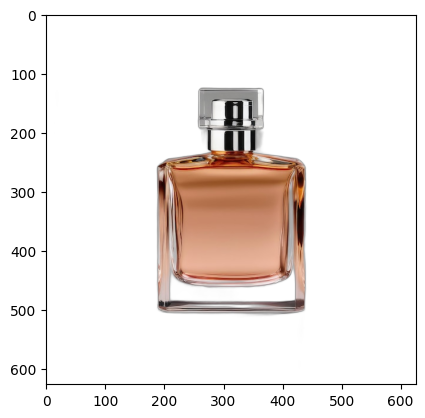

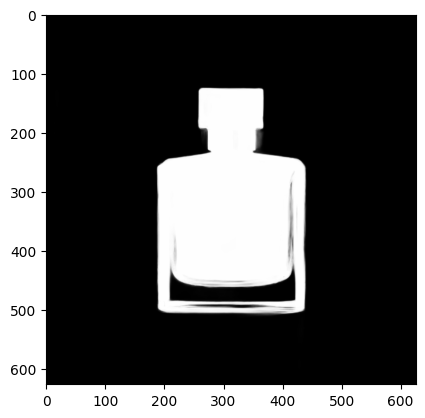

In [10]:
import matplotlib.pyplot as plt

# Display the segmented image
plt.imshow(segmented_output)
plt.show()

# Display the mask
plt.imshow(mask_output, cmap='gray')
plt.show()

## Load model

In [11]:
from diffusers import StableDiffusionControlNetInpaintPipeline, ControlNetModel, StableDiffusionInpaintPipeline
from diffusers import DPMSolverMultistepScheduler, DiffusionPipeline

2024-03-21 08:15:15.799999: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-21 08:15:15.800122: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-21 08:15:15.960302: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [12]:
controlnet_inpaint_model = ControlNetModel.from_pretrained(
                "lllyasviel/control_v11p_sd15_inpaint",
                torch_dtype=torch.float16)

controlnet_hed_model = ControlNetModel.from_pretrained(
                "lllyasviel/control_v11p_sd15_softedge",
                torch_dtype=torch.float16,
                )

controlnet_canny = ControlNetModel.from_pretrained(
                "lllyasviel/control_v11p_sd15_canny",
                torch_dtype=torch.float16)

config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/999 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

In [13]:
def make_inpaint_condition(image, text_prompt, image_mask):
    image = Image.fromarray(image)
    image_mask = Image.fromarray(image_mask)
    image = np.array(image.convert("RGB")).astype(np.float32) / 255.0
    image_mask = np.array(image_mask.convert("L")).astype(np.float32) / 255.0

    assert image.shape[0:1] == image_mask.shape[0:1], "image and image_mask must have the same image size"
    image[image_mask > 0.5] = -1  # set as masked pixel.
    image = np.expand_dims(image, 0).transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return image

In [14]:
def get_HED(img: np.ndarray) -> np.ndarray:
    if isinstance(img, Image.Image) == False:
        img = Image.fromarray(img)
    processor = HEDdetector.from_pretrained('lllyasviel/Annotators')
    control_image = processor(img, safe=True)
    control_image_array = np.array(control_image)
    return control_image_array

In [15]:
inpaint_pipeline = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    "digiplay/Juggernaut_final", #Lykon/AbsoluteReality #SG161222/Realistic_Vision_V6.0_B1_noVAE
    controlnet=[controlnet_hed_model,controlnet_inpaint_model],
    torch_dtype=torch.float16, saftey_check=False).to('cuda')

model_index.json:   0%|          | 0.00/593 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/520 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.58k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/427 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.69k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/582 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Keyword arguments {'saftey_check': False} are not expected by StableDiffusionControlNetInpaintPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [16]:
inpaint_pipeline.scheduler = DPMSolverMultistepScheduler.from_config(
            inpaint_pipeline.scheduler.config, algorithm_type="sde-dpmsolver++", use_karras_sigmas=True)

In [17]:
NUM_SAMPLING_STEPS = 50
CFG_SCALE = 10  # 10.5
CONTROLNET_HED_CONDITIONING_SCALE = 0.5
CONTROLNET_INPAINT_CONDITIONING_SCALE = 1.0
NEGATIVE_PROMPTS = "text++, <UnrealisticDream>, <BadDream>, <bad_prompt_version2>, semi-realistic, cgi, 3d, render, sketch, cartoon, drawing, anime, close up, cropped, out of frame, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, labels, tiny grid, small dots, graphic design, painting, lowres, bad anatomy, bad hands, error, missing fingers, extra digit, fewer digits, low quality, normal quality, signature, watermark, username, blurry"
SAMPLER = "dpm"  # using DPM++ 2M SDE Karras
GENERATED_IMAGE_HEIGHT = new_height
GENERATED_IMAGE_WIDTH = new_width
PROMPT = "Sitting on a table in a forest, surrounded by fruits"

In [18]:
compel = Compel(tokenizer=inpaint_pipeline.tokenizer, text_encoder=inpaint_pipeline.text_encoder)
# ,textual_inversion_manager=textual_inversion_manager)
negative_prompt_embeds = compel(NEGATIVE_PROMPTS)
text_prompt_embed = compel(PROMPT)

In [19]:
canny_image = get_canny(np_input_image)

canny_image = Image.fromarray(canny_image)
control_inpaint_image = make_inpaint_condition(np_input_image, PROMPT, 255 - np_mask_output)
control_hed_image = Image.fromarray(get_HED(input_image))

ControlNetHED.pth:   0%|          | 0.00/29.4M [00:00<?, ?B/s]

In [20]:
seed = None
generator = torch.Generator('cuda').manual_seed(seed) if seed else None

In [21]:
img_list = inpaint_pipeline(
    prompt_embeds=text_prompt_embed,
    image=[Image.fromarray(np_input_image)] * 2,
    mask_image=[Image.fromarray(255 - np_mask_output)] * 2,
    control_image=[control_hed_image, control_inpaint_image],
    num_inference_steps=NUM_SAMPLING_STEPS,
    guidance_scale=CFG_SCALE,
    negative_prompt_embeds=negative_prompt_embeds,
    num_images_per_prompt=2,
    controlnet_conditioning_scale=CONTROLNET_HED_CONDITIONING_SCALE,
    generator=generator,
    height=int(GENERATED_IMAGE_HEIGHT),
    width=int(GENERATED_IMAGE_WIDTH),
    control_guidance_start=[0.0, 0.05],
    control_guidance_end=[0.8, 0.5]
).images

  0%|          | 0/50 [00:00<?, ?it/s]

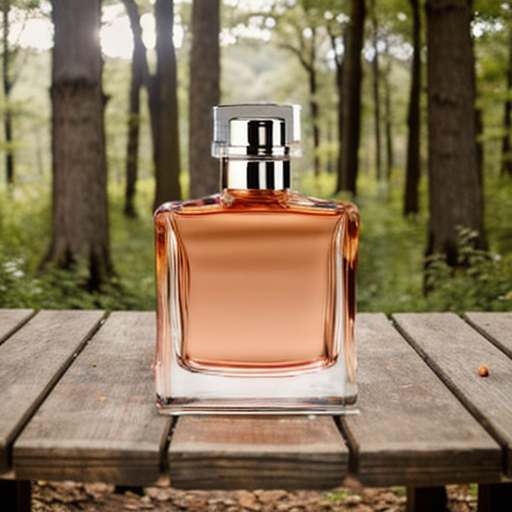

In [22]:
img_list[1]